### 作業目的: 實作word2vec Skip-gram模型
在課程中了解如何搭建CBOW模型，這次的作業目的在於透過搭建Skip-gram模型來了解另外一種word2vec的架構。

Hint_1: 學員可以善用課程中以搭建好的function模組
Hint_2: Skip_gram所需的輸入資料與目標跟CBOW有些許不同，Skip_gram是由中間字詞預測上下文

In [1]:
# import modules
import numpy as np
from typing import List
from utils.utility import clip_grads, convert_one_hot, preprocess, Trainer
from utils.layers import Dense, SoftmaxWithCrossEntropy
from utils.optimizer import SGD

In [2]:
# use the same corpus as in the lecture
text = "I am studying Natural Language Processing now."

# define create_contexts_target function
def create_contexts_target(corpus: List, window_size: int=1):

    targets = []
    contexts = corpus[window_size:-window_size]

    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                # skip target word itself
                continue
            cs.append(corpus[idx + t])
        targets.append(cs)

    return np.array(contexts), np.array(targets)


# transform corpus to contexts and targets pair
corpus, word2idx, idx2word = preprocess([text])
contexts, targets= create_contexts_target(corpus[0], window_size=1)
contexts, targets

(array([5, 7, 3, 0, 1, 6]),
 array([[4, 7],
        [5, 3],
        [7, 0],
        [3, 1],
        [0, 6],
        [1, 2]]))

In [3]:
# transform contexts and targets to one-hot encoding
contexts = convert_one_hot(contexts, len(word2idx))
targets = convert_one_hot(targets, len(word2idx))
contexts, targets

(array([[0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0]]),
 array([[[0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1]],
 
        [[0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0]],
 
        [[0, 0, 0, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 0, 0, 0]],
 
        [[0, 0, 0, 1, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],
 
        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0]],
 
        [[0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0]]]))

In [4]:
# define Skip-gram model
class SkipGram:
    def __init__(self, vocab_size, hidden_size, window_size):
        V, H = vocab_size, hidden_size
        self.window_size = window_size

        # initialize weights
        W_in = 0.01 * np.random.randn(V, H)
        W_out = 0.01 * np.random.randn(H, V)

        # create layers
        self.in_layer = Dense(W_in)
        self.out_layer = Dense(W_out)
        self.loss_layers = [SoftmaxWithCrossEntropy() for i in range(window_size * 2)]
        

        layers = [self.in_layer, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # word vector matrix
        self.word_vecs = W_in

    def forward(self, contexts, targets):
        h = self.in_layer.forward(contexts)
        s = self.out_layer.forward(h)
        
        loss = sum([self.loss_layers[i].forward(s, targets[:, i]) for i in range(self.window_size * 2)])
        return loss

    def backward(self, dout=1):
        
        ds = sum([self.loss_layers[i].backward(dout) for i in range(self.window_size * 2)])
        dh = self.out_layer.backward(ds)
        self.in_layer.backward(dh)
        
        return None

In [5]:
# start training

# configurations
window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

# define model
skip_gram = SkipGram(len(word2idx), hidden_size, window_size)
sgd_optimizer = SGD()
trainer = Trainer(skip_gram, sgd_optimizer)

# start training
trainer.fit(contexts, targets, max_epoch, batch_size)

 20%|█▉        | 196/1000 [00:00<00:00, 1945.77it/s]

Epoch: 1, Iteration: 1/2, Loss: 4.158743611438252
Epoch: 2, Iteration: 1/2, Loss: 4.158993410802887
Epoch: 3, Iteration: 1/2, Loss: 4.158735697261758
Epoch: 4, Iteration: 1/2, Loss: 4.1587627344531315
Epoch: 5, Iteration: 1/2, Loss: 4.158641617771647
Epoch: 6, Iteration: 1/2, Loss: 4.158575679516678
Epoch: 7, Iteration: 1/2, Loss: 4.158732933366427
Epoch: 8, Iteration: 1/2, Loss: 4.158418778733304
Epoch: 9, Iteration: 1/2, Loss: 4.158603833098859
Epoch: 10, Iteration: 1/2, Loss: 4.15835095671944
Epoch: 11, Iteration: 1/2, Loss: 4.158068379039738
Epoch: 12, Iteration: 1/2, Loss: 4.158403407533301
Epoch: 13, Iteration: 1/2, Loss: 4.158058629889173
Epoch: 14, Iteration: 1/2, Loss: 4.158243498816002
Epoch: 15, Iteration: 1/2, Loss: 4.157962667715751
Epoch: 16, Iteration: 1/2, Loss: 4.157596721966199
Epoch: 17, Iteration: 1/2, Loss: 4.158162951514391
Epoch: 18, Iteration: 1/2, Loss: 4.1571672967055635
Epoch: 19, Iteration: 1/2, Loss: 4.1575891676958445
Epoch: 20, Iteration: 1/2, Loss: 4.157

 63%|██████▎   | 632/1000 [00:00<00:00, 2031.39it/s]

Epoch: 409, Iteration: 1/2, Loss: 1.402984401026453
Epoch: 410, Iteration: 1/2, Loss: 1.4031202591672745
Epoch: 411, Iteration: 1/2, Loss: 1.402028683306611
Epoch: 412, Iteration: 1/2, Loss: 1.4023857706981722
Epoch: 413, Iteration: 1/2, Loss: 1.4033776178717834
Epoch: 414, Iteration: 1/2, Loss: 1.4001911316207907
Epoch: 415, Iteration: 1/2, Loss: 1.401414617684261
Epoch: 416, Iteration: 1/2, Loss: 1.4029511907279357
Epoch: 417, Iteration: 1/2, Loss: 1.401960066911045
Epoch: 418, Iteration: 1/2, Loss: 1.4032957016760506
Epoch: 419, Iteration: 1/2, Loss: 1.4000598259016417
Epoch: 420, Iteration: 1/2, Loss: 1.4017356057002208
Epoch: 421, Iteration: 1/2, Loss: 1.4024233333075058
Epoch: 422, Iteration: 1/2, Loss: 1.4003782468420694
Epoch: 423, Iteration: 1/2, Loss: 1.401543367708948
Epoch: 424, Iteration: 1/2, Loss: 1.4028707067313637
Epoch: 425, Iteration: 1/2, Loss: 1.4010724324752815
Epoch: 426, Iteration: 1/2, Loss: 1.4006082027579814
Epoch: 427, Iteration: 1/2, Loss: 1.400827608804343

100%|██████████| 1000/1000 [00:00<00:00, 2144.02it/s]

Epoch: 813, Iteration: 1/2, Loss: 1.3913746261718658
Epoch: 814, Iteration: 1/2, Loss: 1.391644024568121
Epoch: 815, Iteration: 1/2, Loss: 1.3920755576635993
Epoch: 816, Iteration: 1/2, Loss: 1.391395279051098
Epoch: 817, Iteration: 1/2, Loss: 1.3913553136656867
Epoch: 818, Iteration: 1/2, Loss: 1.3919974202422967
Epoch: 819, Iteration: 1/2, Loss: 1.3915943224579432
Epoch: 820, Iteration: 1/2, Loss: 1.3908975978351887
Epoch: 821, Iteration: 1/2, Loss: 1.391733343953875
Epoch: 822, Iteration: 1/2, Loss: 1.3917770524149966
Epoch: 823, Iteration: 1/2, Loss: 1.391301782790856
Epoch: 824, Iteration: 1/2, Loss: 1.3918507711463042
Epoch: 825, Iteration: 1/2, Loss: 1.3913453772727364
Epoch: 826, Iteration: 1/2, Loss: 1.3915817732132747
Epoch: 827, Iteration: 1/2, Loss: 1.3913129284014563
Epoch: 828, Iteration: 1/2, Loss: 1.3917187129000093
Epoch: 829, Iteration: 1/2, Loss: 1.3912246758714213
Epoch: 830, Iteration: 1/2, Loss: 1.3912697731051542
Epoch: 831, Iteration: 1/2, Loss: 1.39191213160679

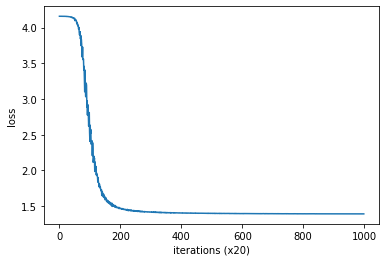

In [6]:
trainer.plot()

In [7]:
# check skip-gram results
word_vec = skip_gram.word_vecs
for i in word2idx.keys():
    print(i,':',word_vec[word2idx[i]])

language : [-2.35553051  1.66218403  0.81758376  0.23098241  0.99074151]
processing : [ 0.77351129  0.37766188  0.37698466 -2.66391566  0.46588108]
. : [ 0.00731923 -0.01722419 -0.00193782  0.01087549 -0.00870397]
natural : [ 1.30576896 -1.68907812 -1.79722907 -1.51560245 -0.0351501 ]
i : [ 0.00843583 -0.0069537  -0.00501326  0.00985574  0.0028239 ]
am : [ 1.94908085 -1.07066873 -1.101271    1.5390706  -0.06243295]
now : [-0.09163671  0.45690414  2.12446589  1.79903814  0.77317635]
studying : [-2.12251007  0.41067518 -0.62633774 -0.44384983 -1.66396388]
